# LSTM and Glove Embeddings

Works on Colab

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout, Bidirectional, Flatten
from tensorflow.keras.models import Sequential


from gensim.models.word2vec import Word2Vec
import gensim.downloader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Juat using text

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

train = df_train.drop(columns=['id','keyword','location'])
test =  df_test.drop(columns=['id','keyword','location'])

# X = df_train['text']
# y = df_train['target']

# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 972)

First, some minor cleaning

In [3]:
def tweet_cleaner(df, feature = 'text', is_train=True, stemmer = PorterStemmer(), include_username=True):
  '''
  made for tweet texts

  input: Dataframe(for test set, set is_train to False)
         feature: whatever the name of the text feature is. default is 'text'
         is_train: set to False if input dataframe is test.csv. else leave as default
         include_username: True (default) means @username -> username
                           False means @username ... have not implemented yet
         stemmer = Stemming object that does the steming. must have a .stem() method. PorterStemmer is default

  output: list_of_words = returns of list of lists. each inner list has the full words as elements
          list_of_stems = returns of list of lists. each inner list has the stemmed words as elements
          list_of_sentences = returns list of 'list_of_words' joined
          labels = returns a list of the target labels. returns empty list if is_train=False



  '''
  list_of_words = []
  list_of_stems = []
  list_of_sentences = []
  list_of_stemmed_sentences = []
  labels = []

  for index, row in df.iterrows():

    if is_train:
      labels.append(row['target'])

    # only alphanumeric words for now.
    pattern = r'\b[a-zA-Z]+\b'


    # including new stopwords unique to tweets. and adding them to nltk

    stops = nltk.corpus.stopwords.words('english')
    new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
    stops.extend(new_stop_words)

    # Gets list of words from re.findall() and filters out stop words and 1 letter words

    word_list = [x.lower() for x in re.findall(pattern, row[feature]) if (x not in stops) and (len(x)>1)]

    # stems the words
    stemmed_tokens = [stemmer.stem(token) for token in word_list]

    list_of_words.append(word_list)
    list_of_stems.append(stemmed_tokens)
    list_of_sentences.append(" ".join(word_list))
    list_of_stemmed_sentences.append(' '.join(stemmed_tokens))




  return list_of_words, list_of_stems,  list_of_sentences, list_of_stemmed_sentences, labels


In [4]:
def remove_usernames_links(tweet):
    tweet = re.sub('@[^\s]+','',tweet) # removes usernames
    tweet = re.sub('http[^\s]+','',tweet) # removes urls
    tweet = re.sub('https[^\s]+','',tweet)
    tweet = re.sub('www[^\s]+','',tweet)
    return tweet


In [10]:
cleaned_train = df_train.copy()
tokens, stems, sentences, stemmed_sentences, labels = tweet_cleaner(df_train)
cleaned_train['cleaned_words'] = sentences
cleaned_train['cleaned_words'] = cleaned_train['cleaned_words'].apply(remove_usernames_links)
cleaned_train['stemmed_sentences'] = stemmed_sentences
cleaned_train['stems'] = stems

In [8]:
cleaned_test = df_test.copy()
tokens, stems, sentences, stemmed_sentences, labels = tweet_cleaner(df_test, is_train=False)
cleaned_test['cleaned_words'] = sentences
cleaned_test['cleaned_words'] = cleaned_test['cleaned_words'].apply(remove_usernames_links)
cleaned_test['stems'] = stems


In [7]:
cleaned_train.to_csv('cleaned_train.csv', index=False)
cleaned_test.to_csv('cleaned_test.csv', index=False)

In [ ]:
cleaned_train.head()

,id,keyword,location,text,target,cleaned_words,stems
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds reason earthquake may allah forgive us,"[our, deed, reason, earthquak, may, allah, for..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked shelter place notified off...,"[all, resid, ask, shelter, place, notifi, offi..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,"[peopl, receiv, wildfir, evacu, order, califor..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...,"[just, got, sent, photo, rubi, alaska, smoke, ..."


In [ ]:
train.loc[7610,'text']

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'

In [ ]:
sentences[7610]

'utc volcano hawaii'

In [ ]:
train.loc[128,'text']

"'Remembering that you are going to die is the best way I know to avoid the trap of thinking you have something to lose.' \x89ÛÒ Steve Jobs"

In [ ]:
sentences[128]

'remembering going die best way know avoid trap thinking something lose steve jobs'

In [ ]:
train.loc[5,'text']

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [ ]:
sentences[5]

'rockyfire update california hwy closed directions due lake county fire cafire wildfires'

In [ ]:
train.loc[33,'text']

'#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'

In [ ]:
train.loc[199,'text']

"\x89ÛÏ@LeoBlakeCarter: This dog thinks he's an ambulance ?????? http://t.co/MG1lpGr0RM\x89Û\x9d@natasha_rideout"

In [ ]:
sentences[199]

'leoblakecarter this dog thinks ambulance'

In [ ]:
sentences[33]

'africanbaze breaking news nigeria flag set ablaze aba'

In [ ]:
train.loc[31,'text']

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [ ]:
sentences[31]

'bbcmtd wholesale markets ablaze'

Train test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_train['cleaned_words'],cleaned_train['target'], random_state = 972, stratify=cleaned_train['target'])

Ok now I tokenize(turn to numbers), and pad

In [25]:
max_sequence_length = 100  # Adjust as needed
max_words = 6000  # Adjust as needed

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post',truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post',truncating='post')

In [ ]:
X_train_padded.shape

(5709, 100)

Ok now I'm going to just downlaod the glove embeddings

In [27]:
# Load pretrained GloVe embeddings
embedding_dim = 25  # Adjust based on the chosen GloVe model dimension
embedding_matrix = np.zeros((max_words, embedding_dim))

glove_path = 'glove.twitter.27B.25d.txt'


with open(glove_path, encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        if word in tokenizer.word_index and tokenizer.word_index[word] < max_words:
            embedding_vector = np.array(values[1:], dtype='float32')
            embedding_matrix[tokenizer.word_index[word]] = embedding_vector

In [28]:
embedding_matrix.shape

(6000, 25)

Try a Keras LSTM

In [29]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=True))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(64,return_sequences = False)))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 25)           150000    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          46080     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 295025 (1.13 MB)
Trainable params: 295025 

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [31]:
model.fit(X_train_padded,
          np.asarray(y_train),
          validation_data = (X_test_padded, np.asarray(y_test)),
          epochs=4,
          batch_size=64)




Epoch 1/4
90/90 [==============================] - 52s 479ms/step - loss: 0.4983 - accuracy: 0.7712 - val_loss: 0.4643 - val_accuracy: 0.7826
Epoch 2/4
90/90 [==============================] - 42s 469ms/step - loss: 0.4379 - accuracy: 0.8056 - val_loss: 0.4349 - val_accuracy: 0.8099
Epoch 3/4
90/90 [==============================] - 38s 419ms/step - loss: 0.4034 - accuracy: 0.8250 - val_loss: 0.4274 - val_accuracy: 0.8141
Epoch 4/4
90/90 [==============================] - 40s 443ms/step - loss: 0.3755 - accuracy: 0.8418 - val_loss: 0.4196 - val_accuracy: 0.8157


Time for the reckoning

60/60 [==============================] - 9s 149ms/step
TN: 957
FP: 129
FN: 222
TP: 596
Sensitivity: 0.7286063569682152
Specificity: 0.8812154696132597
Validation Accuracy: 0.8156512605042017


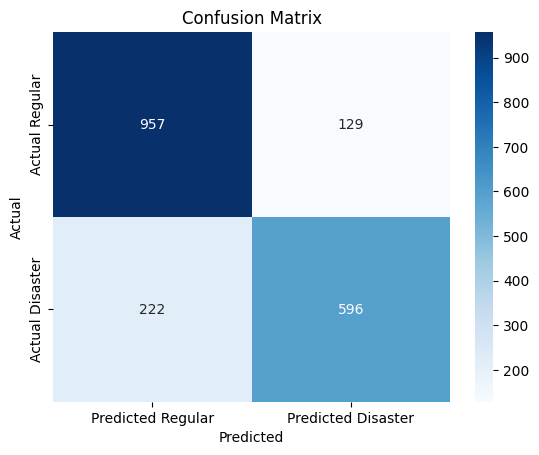

<ipython-input-91-f22b4a8cf18b>:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


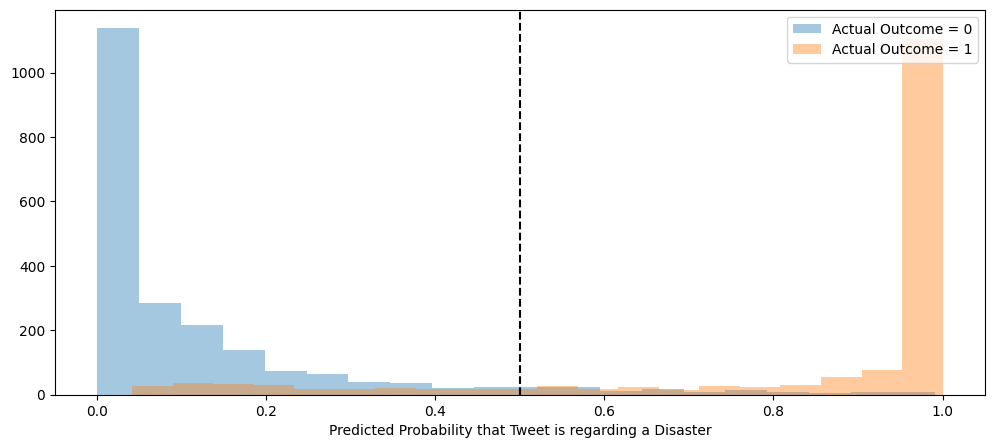

In [91]:
def keras_evaluations(model, X_test_in_model, y_test_truth, decision_boundary=0.5):

  predict_probs = model.predict(X_test_in_model)

  preds = (predict_probs > decision_boundary).astype(int)

  conf_matrix = confusion_matrix(y_test_truth, preds)

  tn, fp, fn, tp = conf_matrix.ravel()

  print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

  print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  reshaped_probs = [l[0] for l in predict_probs]
  pred_df = pd.DataFrame({'true_values': y_test_truth, 'pred_probs': reshaped_probs})

  plt.figure(figsize = (12, 5))
  # plot distributions of predicted probabilities by actual values
  for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

  # Add cutoff line
  plt.axvline(decision_boundary, color = 'black', linestyle = '--')

  plt.xlabel('Predicted Probability that Tweet is regarding a Disaster')
  plt.legend();











keras_evaluations(model, X_test_padded, y_test, decision_boundary=0.5)

In [89]:
predict_probs = model.predict(X_test_padded)


60/60 [==============================] - 3s 57ms/step


In [73]:
def find_cm(y, preds):
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()

    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

    return tn, fp, fn, tp


# Get predictions
preds = (predict_probs > 0.5).astype(int)
# Save confusion matrix values
tn, fp, fn, tp = find_cm(y_test, preds)

TN: 957
FP: 129
FN: 222
TP: 596
Sensitivity: 0.7286063569682152
Specificity: 0.8812154696132597
Validation Accuracy: 0.8156512605042017


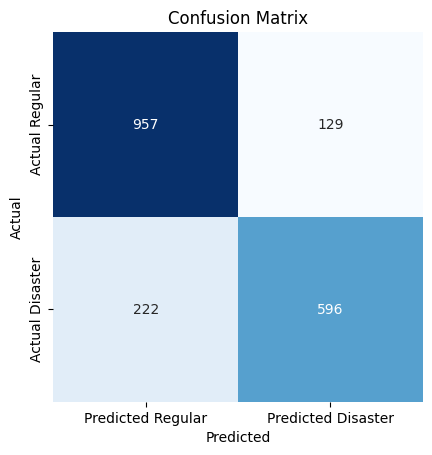

In [75]:
conf_matrix = confusion_matrix(y_test, preds)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



<ipython-input-81-f387588c0cbe>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


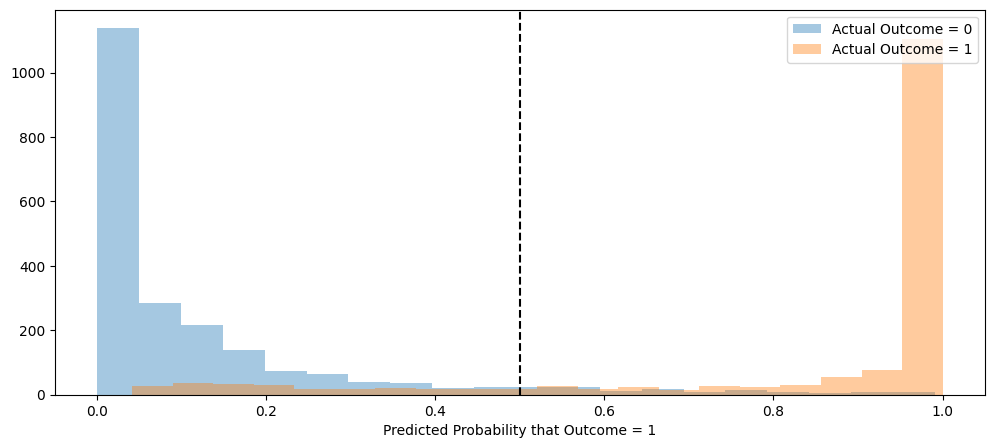

In [81]:
reshaped_probs = [l[0] for l in predict_probs]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': reshaped_probs})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

OK now I'll try shifting to 0.4

In [82]:
def find_cm(y, preds):
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()

    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

    return tn, fp, fn, tp


# Get predictions
preds = (predict_probs > 0.4).astype(int)
# Save confusion matrix values
tn, fp, fn, tp = find_cm(y_test, preds)

TN: 909
FP: 177
FN: 189
TP: 629
Sensitivity: 0.7689486552567237
Specificity: 0.8370165745856354
Validation Accuracy: 0.8077731092436975


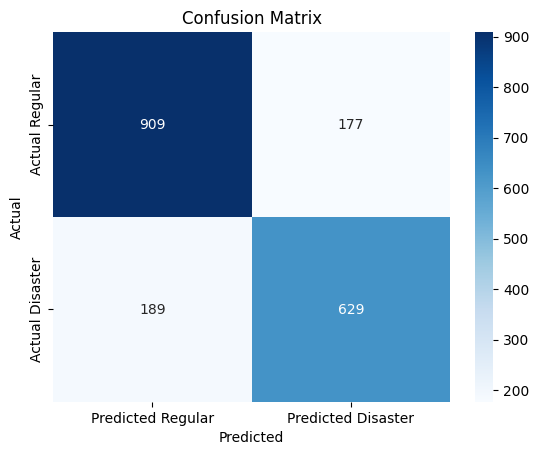

In [83]:
conf_matrix = confusion_matrix(y_test, preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-84-48ad4792e44e>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


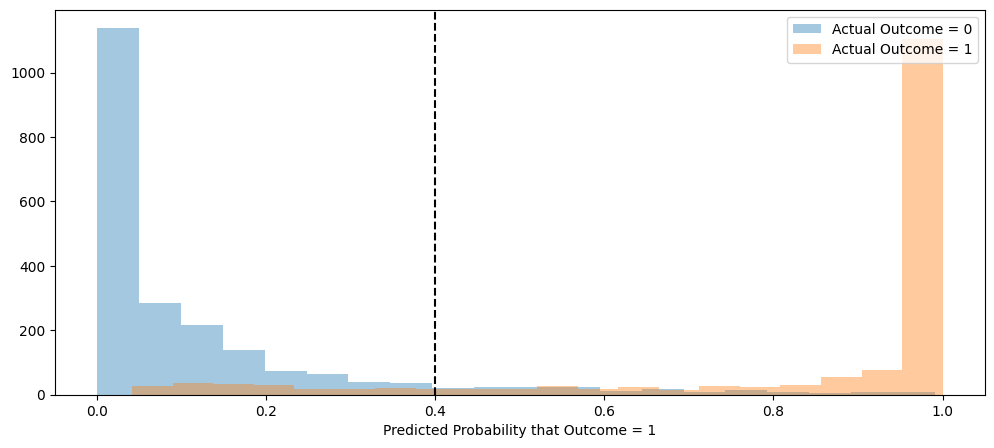

In [84]:
reshaped_probs = [l[0] for l in predict_probs]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': reshaped_probs})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.4, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

Ok shifting to 0.2

In [85]:
def find_cm(y, preds):
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()

    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

    return tn, fp, fn, tp


# Get predictions
preds = (predict_probs > 0.2).astype(int)
# Save confusion matrix values
tn, fp, fn, tp = find_cm(y_test, preds)

TN: 698
FP: 388
FN: 100
TP: 718
Sensitivity: 0.8777506112469438
Specificity: 0.6427255985267035
Validation Accuracy: 0.7436974789915967


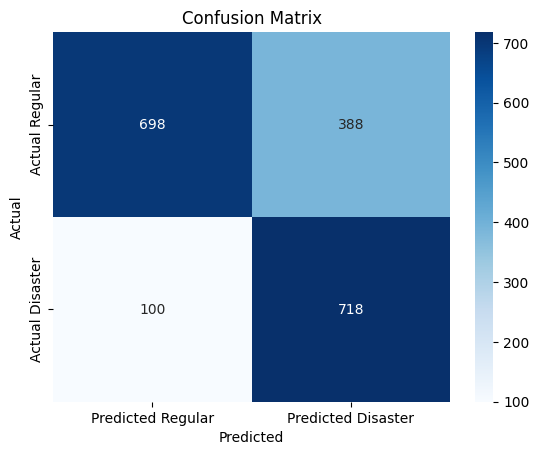

In [86]:
conf_matrix = confusion_matrix(y_test, preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-88-51fdf353a1d7>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


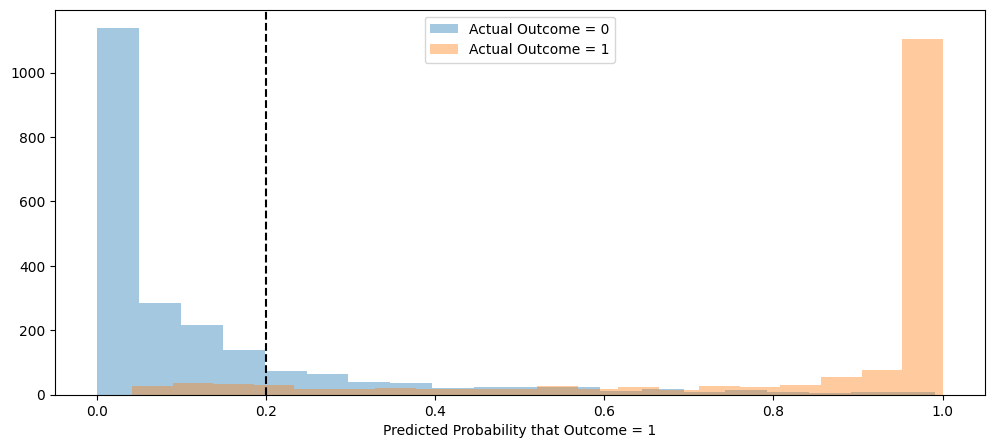

In [88]:
reshaped_probs = [l[0] for l in predict_probs]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': reshaped_probs})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.2, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

Ok, time to get the kaggle submission ready

In [ ]:
max_sequence_length = 100  # Adjust as needed
max_words = 6000  # Adjust as needed

X_kaggle_seq = tokenizer.texts_to_sequences(cleaned_test['cleaned_words'])

X_kaggle_padded = pad_sequences(X_kaggle_seq, maxlen=max_sequence_length, padding='post',truncating='post')


In [ ]:
predictions = model.predict(X_kaggle_padded)

102/102 [==============================] - 8s 81ms/step


In [ ]:
binary_predictions = (predictions > 0.5).astype(int)

In [ ]:
kaggle_submission = cleaned_test.drop(columns=['keyword', 'location', 'text', 'cleaned_words', 'stems']) # everything but 'id'
kaggle_submission['target'] = binary_predictions

In [ ]:
kaggle_submission.to_csv('test_submission.csv', index=False)

In [ ]:
cleaned_test.columns

Index(['id', 'keyword', 'location', 'text', 'cleaned_words', 'stems'], dtype='object')

In [ ]:
import pickle

with open('arjun_model.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(model, file)

## MNB with stemmming

In [94]:
X_train_stems, X_test_stems, y_train_stems, y_test_stems = train_test_split(cleaned_train['stemmed_sentences'],cleaned_train['target'], random_state = 972, stratify=cleaned_train['target'])

In [12]:
mnb_params = {
        'tfidf__max_features': [2000,3000, 4000],
        'tfidf__min_df': [1,5,10],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 2)],}

tgif_mnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])
mnb_gs = GridSearchCV(tgif_mnb_pipe, param_grid=mnb_params)
mnb_gs.fit(X_train_stems,y_train_stems)


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 3000, 4000],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 2)],
                         'tfidf__stop_words': [None]})

In [92]:
def keras_evaluations(model, X_test_in_model, y_test_truth, decision_boundary=0.5):

  predict_probs = model.predict(X_test_in_model)

  preds = (predict_probs > decision_boundary).astype(int)

  conf_matrix = confusion_matrix(y_test_truth, preds)

  tn, fp, fn, tp = conf_matrix.ravel()

  print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

  print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  reshaped_probs = [l[0] for l in predict_probs]
  pred_df = pd.DataFrame({'true_values': y_test_truth, 'pred_probs': reshaped_probs})

  plt.figure(figsize = (12, 5))
  # plot distributions of predicted probabilities by actual values
  for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

  # Add cutoff line
  plt.axvline(decision_boundary, color = 'black', linestyle = '--')

  plt.xlabel('Predicted Probability that Tweet is regarding a Disaster')
  plt.legend();

In [15]:
mnb_gs.best_params_

{'tfidf__max_df': 0.9,
 'tfidf__max_features': 4000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [14]:
mnb_gs.score(X_train_stems,y_train_stems), mnb_gs.score(X_test_stems,y_test_stems)


(0.8476090383604834, 0.8182773109243697)

In [96]:
def sklearn_evaluations(model, X_test_in_model, y_test_truth, dec_bound = 0.5):



  predict_prob = model.predict_proba(X_test_in_model)[:,1]

  preds = (predict_probs > dec_bound).astype(int)

  conf_matrix = confusion_matrix(y_test_truth, preds)


  tn, fp, fn, tp = conf_matrix.ravel()

  print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

  print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()



  #reshaped_probs = [l[0] for l in predict_probs]
  pred_df = pd.DataFrame({'true_values': y_test_truth,'pred_probs': predict_prob})

  plt.figure(figsize = (12, 5))

  # plot distributions of predicted probabilities by actual values
  for group in pred_df.groupby('true_values'):
      sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

  # Add cutoff line
  plt.axvline(dec_bound, color = 'black', linestyle = '--')

  plt.xlabel('Predicted Probability that Outcome = 1')
  plt.legend();



TN: 833
FP: 253
FN: 146
TP: 672
Sensitivity: 0.8215158924205379
Specificity: 0.7670349907918969
Validation Accuracy: 0.7904411764705882


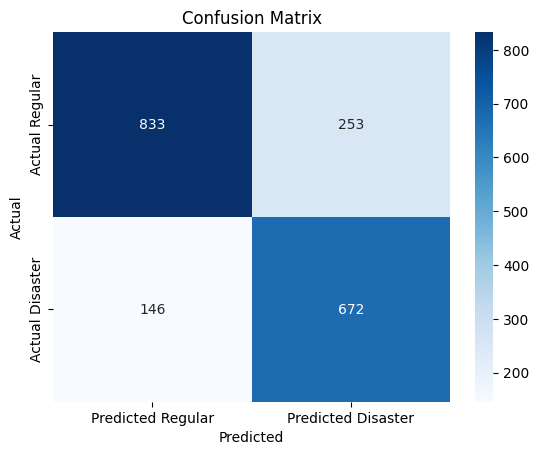

<ipython-input-96-e2135bb9e65b>:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


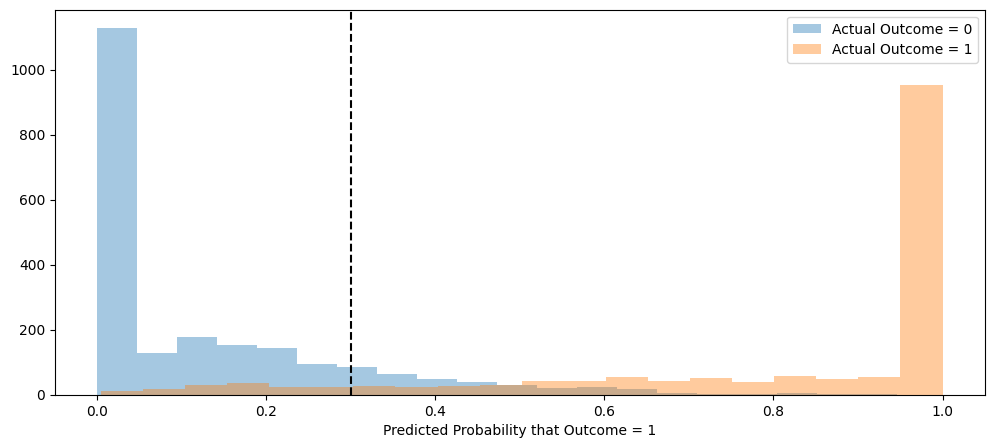

In [99]:
sklearn_evaluations(mnb_gs, X_test_stems, y_test_stems, dec_bound = 0.3)

In [18]:
def find_cm(preds):
    tn, fp, fn, tp = confusion_matrix(y_test_stems, preds).ravel()

    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}")

    return tn, fp, fn, tp
# Get predictions
preds = mnb_gs.predict(X_test_stems,)
# Save confusion matrix values
tn, fp, fn, tp = find_cm(preds)

TN: 992
FP: 94
FN: 252
TP: 566
Sensitivity: 0.6919315403422983
Specificity: 0.9134438305709024


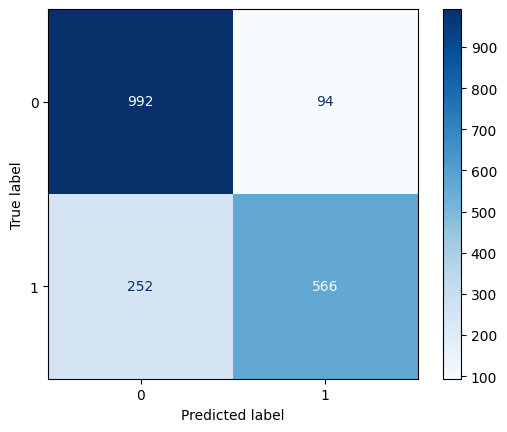

In [19]:
ConfusionMatrixDisplay.from_estimator(mnb_gs, X_test_stems, y_test_stems, cmap='Blues', values_format='d');

<ipython-input-23-1676f1ad1681>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


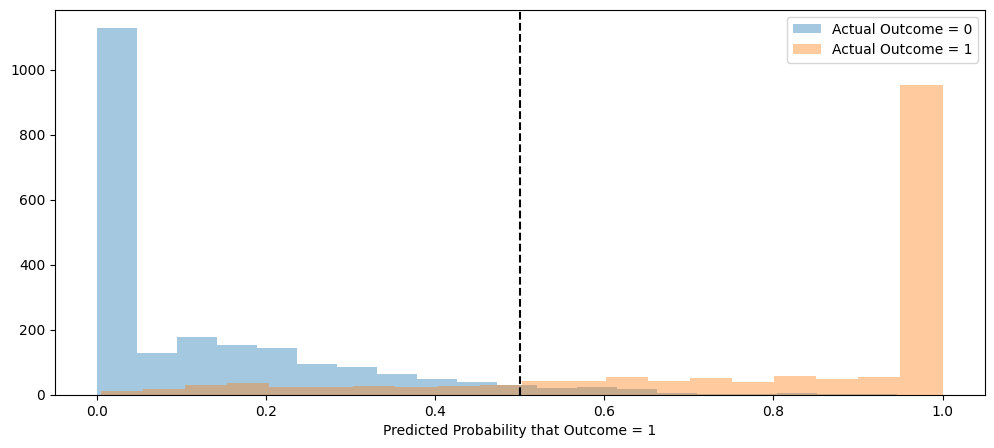

In [23]:
pred_df = pd.DataFrame({'true_values': y_test_stems,
                        'pred_probs': mnb_gs.predict_proba(X_test_stems)[:,1]})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

# Trying out making our own embeddings using word2vec

In [ ]:
# Train a word2vec model!
wv = Word2Vec(sentences=sentences,      # Corpus of data.
              vector_size=30,    # How many dimensions do you want in your word vector?
              window=4,    # How many "context words" do you want?
              min_count=1, # Ignores words below this threshold.
              sg=0,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
              workers=4)   # Number of "worker threads" to use (parallelizes process).c

In [ ]:
wv.wv.most_similar('women', topn=100)

[('since', 0.9988051056861877),
 ('us', 0.9983085989952087),
 ('amp', 0.9983000755310059),
 ('best', 0.9982950687408447),
 ('first', 0.9980924129486084),
 ('you', 0.9980767369270325),
 ('like', 0.9980363845825195),
 ('red', 0.9980309009552002),
 ('new', 0.9980042576789856),
 ('day', 0.99798983335495),
 ('in', 0.997977614402771),
 ('county', 0.99797523021698),
 ('he', 0.9979395866394043),
 ('run', 0.9978729486465454),
 ('my', 0.9978727698326111),
 ('the', 0.9978623390197754),
 ('even', 0.997861921787262),
 ('2', 0.9978586435317993),
 ('fires', 0.9978358149528503),
 ('food', 0.9978311061859131),
 ('would', 0.9978294372558594),
 ('live', 0.9978278279304504),
 ('emergency', 0.9978129863739014),
 ('many', 0.9977896809577942),
 ('two', 0.9977848529815674),
 ('still', 0.9977837800979614),
 ('collapse', 0.9977515339851379),
 ('fire', 0.9977496862411499),
 ('i', 0.9977399706840515),
 ('back', 0.997736930847168),
 ('3', 0.9976901412010193),
 ('crash', 0.9976752400398254),
 ('china', 0.9976679682

Ok turns out, gensim already has pretrained embedding eights in it


In [ ]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
glove_vectors.mos()

AttributeError: ignored

# ok now, I will use tfidf with the stemmed words


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(stems,labels, random_state = 972, stratify=labels)

NameError: name 'stems' is not defined

In [ ]:
X_train[0]

['polic', 'offic', 'wound', 'suspect', 'dead', 'after', 'exchang', 'shot']

In [ ]:
len(text)

7613

In [ ]:
train.loc[5,'text']

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [ ]:
text[5]

'rockyfir updat california hwi 20 close direct due lake counti fire cafir wildfir'

In [ ]:
vocab_size = 5000 # Max number of words
embedding_dim = 64 # Word Vector dimension
max_length = 200 # Max length of the sequence
trunc_type = 'post' # where to chop off
padding_type = 'post' # where to put the padding
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(text)


In [ ]:
text_numbered = tokenizer.texts_to_sequences(text)

In [ ]:
text_numbered[5]

[2678, 242, 60, 1421, 681, 394, 907, 551, 1004, 418, 8, 3970, 134]

In [ ]:
text_padded = pad_sequences(text_numbered, maxlen=max_length, padding= padding_type,truncating = trunc_type)

In [ ]:
text_padded[5]

array([2678,  242,   60, 1421,  681,  394,  907,  551, 1004,  418,    8,
       3970,  134,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(text_padded),np.asarray(labels), random_state = 972)

In [ ]:
# @title Default title text
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 5, input_length = max_length))
#model.add(LSTM(16, return_sequences = True))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 5)            25000     
                                                                 
 bidirectional_19 (Bidirect  (None, 64)                9728      
 ional)                                                          
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 36841 (143.91 KB)
Trainable params: 36841 (143.91 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [ ]:
model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])


In [ ]:
X_train[0].shape

(200,)

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test),
          batch_size = 256, epochs = 10)

Epoch 1/10
23/23 [==============================] - 10s 222ms/step - loss: 0.6853 - acc: 0.5670 - val_loss: 0.6816 - val_acc: 0.5683
Epoch 2/10
23/23 [==============================] - 5s 225ms/step - loss: 0.6725 - acc: 0.5710 - val_loss: 0.6598 - val_acc: 0.5683
Epoch 3/10
23/23 [==============================] - 3s 119ms/step - loss: 0.6196 - acc: 0.6716 - val_loss: 0.6015 - val_acc: 0.7096
Epoch 4/10
23/23 [==============================] - 3s 138ms/step - loss: 0.5136 - acc: 0.7849 - val_loss: 0.4947 - val_acc: 0.7747
Epoch 5/10
23/23 [==============================] - 3s 144ms/step - loss: 0.3960 - acc: 0.8364 - val_loss: 0.4792 - val_acc: 0.7784
Epoch 6/10
23/23 [==============================] - 3s 113ms/step - loss: 0.3316 - acc: 0.8662 - val_loss: 0.4935 - val_acc: 0.7915
Epoch 7/10
23/23 [==============================] - 2s 86ms/step - loss: 0.2893 - acc: 0.8861 - val_loss: 0.4977 - val_acc: 0.7857
Epoch 8/10
23/23 [==============================] - 2s 62ms/step - loss: 0.2

Ok now doing word2vec

In [ ]:
# Train a model!
wv = Word2Vec(corpus,      # Corpus of data.
              size=100,    # How many dimensions do you want in your word vector?
              window=2,    # How many "context words" do you want?
              min_count=1, # Ignores words below this threshold.
              sg=0,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
              workers=4)   # Number of "worker threads" to use (parallelizes process).
